In [1]:
%matplotlib widget
import os
os.environ["GDAL_DATA"] = "/srv/conda/envs/notebook/share/gdal" # need to specify to make gdal work
os.environ["PROJ_LIB"] = "/srv/conda/envs/notebook/share/proj" # need to specify to make pyproj work
os.environ["PROJ_DATA"] = "/srv/conda/envs/notebook/share/proj" # need to specify to make pyproj work
import numpy as np
import geopandas as gpd
from ipyleaflet import Map, basemaps, Polygon, Polyline, GeoData, LayersControl

Plot the Area of Interest 

In [2]:
# I just drew these randomly on a map...
shape = 'data/shapefiles/petermann_marginal_lake.geojson'
shape_buffer = 'data/shapefiles/petermann_marginal_lake_buffer.geojson'

gdf = gpd.read_file(shape_buffer)
geom = [i for i in gdf.geometry]
lons,lats = geom[0].exterior.coords.xy
shape_buffer_coords = list(zip(lats,lons))
gdf = gpd.read_file(shape)
geom = [i for i in gdf.geometry]
lons,lats = geom[0].exterior.coords.xy
shape_coords = list(zip(lats,lons))
shape_bounds = [[np.min(lats),np.min(lons)], [np.max(lats),np.max(lons)]]

m=Map(basemap=basemaps.Esri.WorldImagery,center=[np.mean(lats),np.mean(lons)],zoom=9)
m.fit_bounds(shape_bounds)
polygon = Polygon(locations=shape_buffer_coords, color="green", fill_color="blue", name='polygon_buffered')
m.add_layer(polygon)
polygon2 = Polygon(locations=shape_coords, color="blue", fill_color="blue", name='polygon')
m.add_layer(polygon2)
m.add_control(LayersControl())
m

Map(center=[80.27525120758935, -60.04105881133702], controls=(ZoomControl(options=['position', 'zoom_in_text',…

Download the ICESat-2 data over this area

In [3]:
# import the utility function for ICESat-2 data downloads
from utils.nsidc import download_is2

In [4]:
# this is just to get the earthdata credits into the notebook without pushing them to github
# can just specify them directly here like below
# uid = 'insert_your_earthdata_user_id_here'
# pwd = 'insert_your_earthdata_password_here'
from ed.edcreds import getedcreds
uid, pwd, email = getedcreds()

# to set up the getedcreds() function:
# - create a folder called "ed"
# - in this folder, create an empty file called "__init__.py"
# - in this folder, creat a file called "edcreds.py", with the following function:
#   def getedcreds(): return '<your_earthdata_user_id>', '<your_earthdata_password>', '<your_email_address>'
# - if you push to github, make sure to include the folder ed/ in your .gitignore

In [33]:
# if you want ATL03 data
download_is2(short_name='ATL06', 
             start_date='2018-01-01', 
             end_date='2030-01-01', 
             uid=uid, 
             pwd=pwd, 
             shape=shape_buffer, 
             output_dir='data/IS2')

In [ ]:
# # if you want ATL03 data, you could run the code below
# download_is2(short_name='ATL03', 
#              start_date='2018-01-01', 
#              end_date='2030-01-01', 
#              uid=uid, 
#              pwd=pwd, 
#              shape=shape_buffer, 
#              output_dir='data/IS2')

Get a list of all the ATL06 data files over this region

In [6]:
search_for = 'ATL06_'
search_in = 'data/IS2/'
filelist = [search_in+f for f in os.listdir(search_in) \
            if os.path.isfile(os.path.join(search_in, f)) & (search_for in f) & ('.h5' in f)]
# filelist.sort()
print('There are %i files.' % len(filelist))

There are 166 files.


Just pick the first file, and plot the ground tracks on the map

In [7]:
from utils.readers import read_atl06

file = filelist[0]
ancillary, dfs = read_atl06(file, verbose=False)
for gtx in dfs.keys():
    dfs[gtx] = dfs[gtx][dfs[gtx].qual_summary == 0]

In [8]:
ancillary

{'granule_id': 'ATL06_20210301011734_10241004_005_01.h5',
 'date': '2021-03-01',
 'atlas_sdp_gps_epoch': 1198800018.0,
 'rgt': 1024,
 'cycle_number': 10,
 'sc_orient': 'forward',
 'gtx_beam_dict': {'gt1l': 6,
  'gt1r': 5,
  'gt2l': 4,
  'gt2r': 3,
  'gt3l': 2,
  'gt3r': 1},
 'gtx_strength_dict': {'gt1l': 'weak',
  'gt1r': 'strong',
  'gt2l': 'weak',
  'gt2r': 'strong',
  'gt3l': 'weak',
  'gt3r': 'strong'}}

In [9]:
dfs[list(dfs.keys())[0]]

,delta_time,lat,lon,xatc,h,geoid_h,qual_summary
0,9.979666e+07,80.240522,-59.802285,8.966637e+06,500.818024,18.545877,0
1,9.979666e+07,80.240697,-59.802514,8.966657e+06,500.350586,18.544523,0
3,9.979666e+07,80.241047,-59.802977,8.966697e+06,502.284637,18.542154,0
4,9.979666e+07,80.241221,-59.803209,8.966717e+06,503.831055,18.540697,0
5,9.979666e+07,80.241396,-59.803442,8.966737e+06,504.999390,18.539362,0
...,...,...,...,...,...,...,...
698,9.979666e+07,80.362534,-59.965551,8.980602e+06,432.017090,17.563314,0
699,9.979666e+07,80.362709,-59.965788,8.980622e+06,430.504364,17.561707,0
700,9.979666e+07,80.362884,-59.966025,8.980642e+06,428.662537,17.560091,0
701,9.979666e+07,80.363058,-59.966263,8.980662e+06,427.356506,17.558588,0


In [26]:
m=Map(basemap=basemaps.Esri.WorldImagery,center=[np.mean(lats),np.mean(lons)],zoom=9)
m.fit_bounds(shape_bounds)
polygon = Polygon(locations=shape_coords, color="blue", fill_color="blue", name='polygon')
m.add_layer(polygon)

# plot the first 15 tracks
nfiles = 15
filelist.sort()
for file in filelist[:nfiles]:
    ancillary, dfs = read_atl06(file, verbose=False)
    for gtx in dfs.keys():
        dfs[gtx] = dfs[gtx][dfs[gtx].qual_summary == 0]
        dfs[gtx].lat, dfs[gtx].lon
        coords = list(zip(dfs[gtx].lat, dfs[gtx].lon))
        weight = 2 if ancillary['gtx_strength_dict'][gtx] == 'strong' else 1
        name = 'track %d-%s' % (ancillary['rgt'], gtx)
        line = Polyline(locations=coords,color="red",weight=weight,fill=False, name=name)
        m.add_layer(line)
    
m.add_control(LayersControl())
m

Map(center=[80.27525120758935, -60.04105881133702], controls=(ZoomControl(options=['position', 'zoom_in_text',…

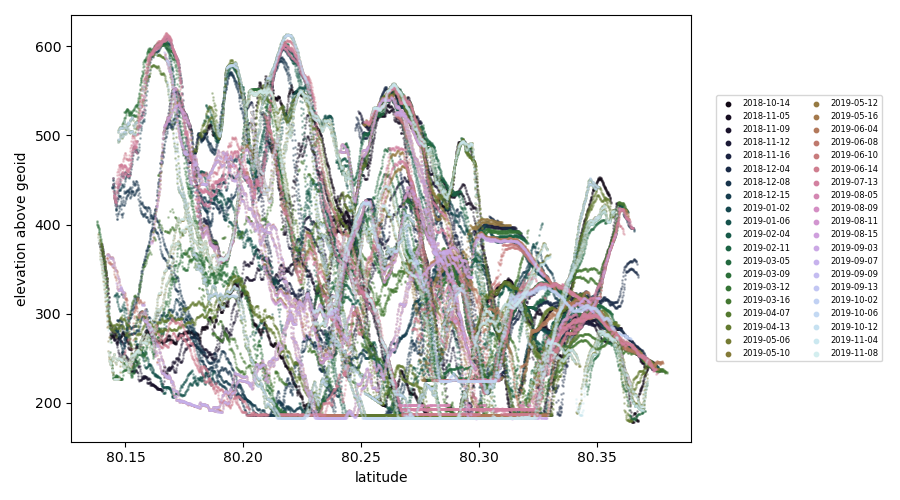

In [31]:
import matplotlib
import matplotlib.pylab as plt


fig, ax = plt.subplots(figsize=[9, 5], dpi=100)
handles = []

# plot the first 40 files
nfiles = 40
colors = cm.cubehelix(np.linspace(0.05,0.9,nfiles))
for i, file in enumerate(filelist[:nfiles]):
    ancillary, dfs = read_atl06(file, verbose=False)
    df = pd.concat(dfs)
    df = df[df.qual_summary == 0].copy()
    df['h_geoid_corrected'] = df.h - df.geoid_h
    df = df[np.abs(df.h_geoid_corrected) < 1e5]
    ax.scatter(df.lat, df.h_geoid_corrected , s=1, alpha=0.3, color=tuple(colors[i,:]))
    scatt = ax.scatter(0, 0 , s=10, alpha=1, color=tuple(colors[i,:]), label=ancillary['date'])
    handles.append(scatt)
# ax.legend(loc='upper right')
plt.legend(handles=handles, bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0, fontsize=6, ncols=2)
ax.set_xlim((80.12685987765869, 80.38980029579673))
ax.set_ylim((156.4133674621582, 634.9853904724121))
ax.set_xlabel('latitude')
ax.set_ylabel('elevation above geoid')
fig.tight_layout()